# Install Transformers Library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install transformers
!pip install transformers==2.5.1

     |████████████████████████████████| 501kB 8.9MB/s 
     |████████████████████████████████| 3.7MB 14.9MB/s 
     |████████████████████████████████| 1.1MB 36.8MB/s 
     |████████████████████████████████| 890kB 55.4MB/s 
     |████████████████████████████████| 133kB 51.8MB/s 
     |████████████████████████████████| 7.1MB 56.0MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=46004f24e941976472fbb74b27ea1e1bb5b84344b29d8fdfc4e927f27609e373
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
ERROR: botocore 1.19.38 has requirement urllib3<1.27,>=1.25.4; python_version != "3.4", but you'll have urllib3 1.24.3 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [6]:
df1= pd.read_csv("/content/drive/MyDrive/IIITD Data/NLP/train_processed.csv")
df3= pd.read_csv("/content/drive/MyDrive/IIITD Data/NLP/test_processed.csv")
df2= pd.read_csv("/content/drive/MyDrive/IIITD Data/NLP/val_processed.csv")

# Load Dataset

In [7]:
# df1 = pd.read_csv("train_processed.csv")
df1 = df1.sample(frac=1)
df1 = df1[:int(len(df1)*0.6)]
# df2 = pd.read_csv("val_processed.csv")
# df3 = pd.read_csv("test_processed.csv")

In [8]:
df = df1

In [9]:
df.head()

,text,label
4872,RT name_id: CoronaWatch total confirmed cases ...,1
2668,Tire repairer who died in a work accident was ...,0
182,While it is true that coronavirus can cause a ...,0
6285,Prime Minister Boris Johnson says a class shou...,1
4728,RT name_id: Deaths per million population in I...,1


In [10]:
df.shape

(3852, 2)

In [11]:
# check class distribution
df['label'].value_counts(normalize = True)

1    0.530893
0    0.469107
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [12]:
train_text, train_labels= df1['text'], df1['label']
val_text, test_text, val_labels= df2['text'],df3['text'], df2['label']

# Import BERT Model and BERT Tokenizer

In [13]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [14]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# Tokenization

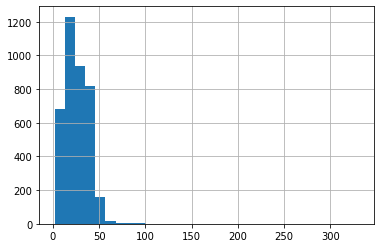

In [18]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [19]:
np.array(seq_len).mean()

25.23546209761163

In [17]:
max_seq_len = 25

In [18]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# Convert Integer Sequences to Tensors

In [19]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
# test_y = torch.tensor(test_labels.tolist())

# Create DataLoaders

In [20]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [21]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [22]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
    #   print(sent_id, mask)
    #   print(type(cls_hs))
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [23]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [24]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

# Find Class Weights

In [25]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[1.06585501 0.94180929]


In [27]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 30

# Fine-Tune BERT

In [28]:
# function to train the model
def train():
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward() # dl/dw

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step() #  w = w_prev - n (dw/dl)

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [29]:
# function for evaluating the model
def evaluate():
  print("\nEvaluating...")
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
    #   elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      # model predictions
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

# Start Model Training

In [30]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 30


/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch    50  of    121.
  Batch   100  of    121.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.568
Validation Loss: 0.423

 Epoch 2 / 30
  Batch    50  of    121.
  Batch   100  of    121.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.440
Validation Loss: 0.418

 Epoch 3 / 30
  Batch    50  of    121.
  Batch   100  of    121.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.455
Validation Loss: 0.558

 Epoch 4 / 30
  Batch    50  of    121.
  Batch   100  of    121.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.410
Validation Loss: 0.370

 Epoch 5 / 30
  Batch    50  of    121.
  Batch   100  of    121.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.417
Validation Loss: 0.350

 Epoch 6 / 30
  Batch    50  of    121.
  Batch   100  of    121.

Evaluating...
  Batch    50  of     67.

Training Loss: 0.383
Validation Loss: 0.380

 Epoch 7 / 30
  Batch    50  of    121.
  Batch   100  of    121.

Evaluating...
  Batch    50  

# Load Saved Model

In [31]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [32]:
# get predictions for test data
with torch.no_grad():
  preds = model(val_seq.to(device), val_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [39]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(val_y, preds))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1020
           1       0.90      0.86      0.88      1120

    accuracy                           0.88      2140
   macro avg       0.88      0.88      0.88      2140
weighted avg       0.88      0.88      0.88      2140



In [40]:
import datetime

x = datetime.datetime.now()
print(str(x.strftime("%H%M%S")))

pd.DataFrame(preds, columns=['label']).to_csv('ans'+str(x.strftime("%H%M%S"))+'.csv', index=None)

075030


--------------------------

Voting of Classes (to be done at the last after running the above code 5 times)

In [ ]:
ans1 = pd.read_csv('/content/ans202137.csv')
ans1 = np.array(ans1['label'])
ans2 = pd.read_csv('/content/ans203152.csv')
ans2 = np.array(ans2['label'])
ans3 = pd.read_csv('/content/ans203649.csv')
ans3 = np.array(ans3['label'])
ans4 = pd.read_csv('/content/ans203952.csv')
ans4 = np.array(ans4['label'])
ans5 = pd.read_csv('/content/ans204153.csv')
ans5 = np.array(ans5['label'])

In [ ]:
ans = pd.DataFrame()
ans["1"] = ans1
ans["2"] = ans2
ans["3"] = ans3
ans["4"] = ans4
ans["5"] = ans5
ans["sum"] = ans["1"] +ans["2"] +ans["3"] +ans["4"] +ans["5"]
def vote(x):
    if x>=3:
        return 1
    return 0
ans["vote"] = ans['sum'].apply(vote)
ans.head()

In [ ]:
print(classification_report(val_y, ans['vote']))